<a href="https://colab.research.google.com/github/nhuang37/GNN_community_detection/blob/main/Experiment_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Utils

In [1]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount("/content/drive")
%cd /content/drive/MyDrive/JHU/Luana

Mounted at /content/drive
/content/drive/MyDrive/JHU/Luana


In [2]:
import math
import random
import os
import numpy as np
import numpy.random as npr
import scipy as sp
from scipy.sparse.linalg import eigsh, eigs
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from scipy.sparse.linalg import eigsh, eigs
from scipy.sparse.linalg.eigen.arpack import ArpackError
from torch.nn.utils.parametrizations import orthogonal
import pickle
import seaborn as sns
import copy
from collections import defaultdict


In [3]:
#source: https://gist.github.com/ihincks/6a420b599f43fcd7dbd79d56798c4e5a
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

### Dense-sparse-graph-model (DSGM) with a chosen W

In [4]:
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
def w_func(x, y, p, q):
  assert p != q, "you have to choose different connection probability within/between blocks!"
  if x * y > 0: #block 0
    return p*(1/(np.abs(x) + 1)**2)*(1/(np.abs(y) + 1)**2)
  else: #block 1
    return q*(1/(np.abs(x) + 1)**2)*(1/(np.abs(y) + 1)**2)


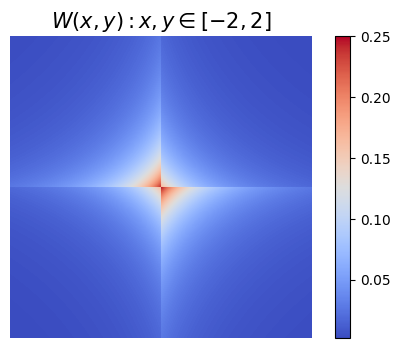

In [5]:
max_val = 2
p = 1/4
q= 1/6
x = arange(-max_val,max_val,0.01)
y = arange(-max_val,max_val,0.01)

Z = np.zeros((len(x) , len(y)))
for x_ind, x_val in enumerate(x):
  for y_ind, y_val in enumerate(y):
    Z[x_ind, y_ind] = w_func(x_val, y_val, p, q)
#Z = np.array(Z).reshape(len(x),len(y))
im = imshow(Z,cmap=cm.coolwarm,extent=[-Z.shape[1]/2., Z.shape[1]/2., -Z.shape[0]/2., Z.shape[0]/2. ])
colorbar(im) # adding the colobar on the right
# latex fashion title
plt.xlabel('$x$',fontsize=15)
plt.ylabel('$y$',fontsize=15)
title('$W(x,y): x, y \in [-2,2]$', fontsize=15)
plt.axis('off')
show()

#### Understand the eigenvalue/eigenfunctions of W
- The first 6 eigenvalues have high energies, with corresponding eigenfunctions exhibit smooth osciliation patterns
- The second eigenfunction can be used to perfectly detect communities
- Deeper in the spectrum, although the eigenvalues are very small, the eigenfunction can still show nontrivial oscilliation (albeit with much higher frequency that might not be useful for community detection with large, balanced blocks)

In [ ]:
#Let's do a finer sampling!
res = 0.005
max_val = 5
x = arange(-max_val,max_val,res)
y = arange(-max_val,max_val,res)
#X,Y = meshgrid(x, y) # grid of point
#Z = w_func(X, Y, p, q) # evaluation of the function on the grid
Z = np.zeros((len(x) , len(y)))
for x_ind, x_val in enumerate(x):
  for y_ind, y_val in enumerate(y):
    Z[x_ind, y_ind] = w_func(x_val, y_val, p, q)

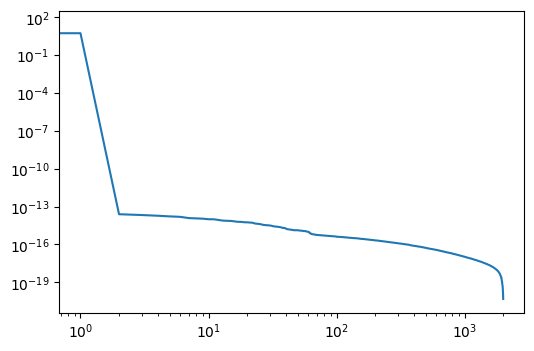

In [ ]:
u2, s2, v2 = np.linalg.svd(Z, hermitian=True)
plt.loglog(s2)
plt.show()

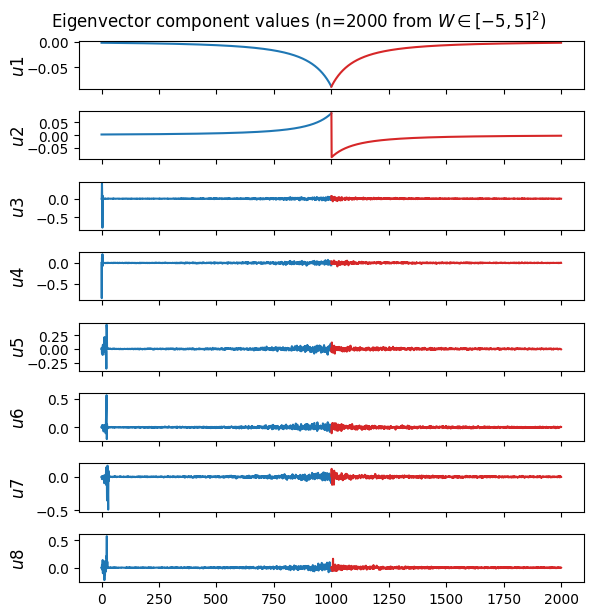

In [ ]:
n = len(s2)
x = np.arange(n)
num_eigen = 8
fig, axs = plt.subplots(nrows=num_eigen,sharex=True, figsize=(6,6), dpi=100)
for i in range(num_eigen):
  axs[i].plot(x[:(n//2)], u2[:(n//2),i], color="tab:blue")
  axs[i].plot(x[(n//2):], u2[(n//2):,i], color="tab:red")
  axs[i].set_ylabel(r"$u$"+str(i+1), fontsize=12)
  axs[i].get_yaxis().set_label_coords(-0.1,0.5)

fig.suptitle("Eigenvector component values (n=2000 from $W \in [-5,5]^2$)", y=1.02)
fig.tight_layout()
plt.show()

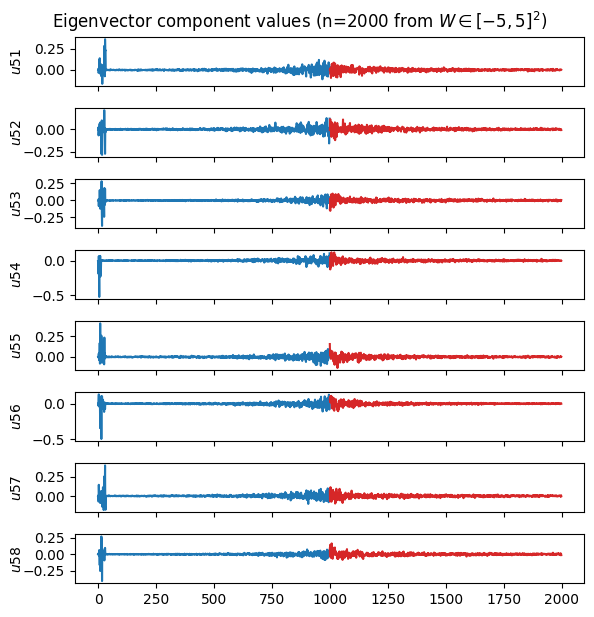

In [ ]:
fig, axs = plt.subplots(nrows=num_eigen,sharex=True, figsize=(6,6), dpi=100)
j = 50
for i in range(num_eigen):
  axs[i].plot(x[:(n//2)], u2[:(n//2),i+j], color="tab:blue")
  axs[i].plot(x[(n//2):], u2[(n//2):,i+j], color="tab:red")
  axs[i].set_ylabel(r"$u$"+str(i+1+j))
  axs[i].get_yaxis().set_label_coords(-0.1,0.5)

fig.suptitle("Eigenvector component values (n=2000 from $W \in [-5,5]^2$)", y=1.02)
fig.tight_layout()
plt.show()

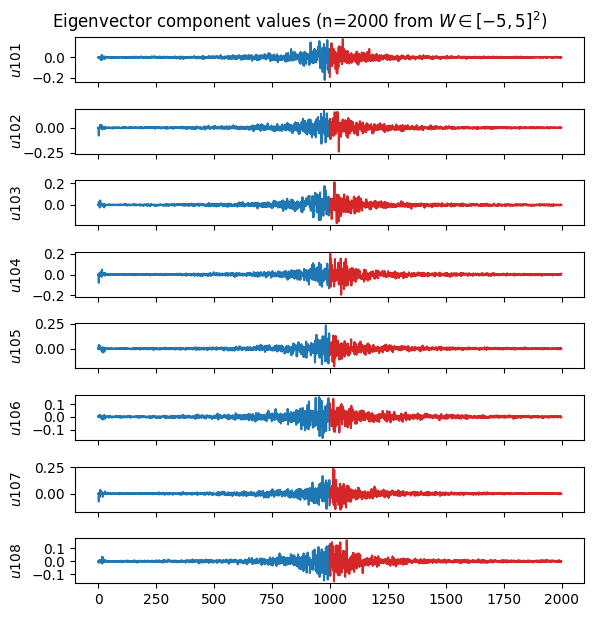

In [ ]:
fig, axs = plt.subplots(nrows=num_eigen,sharex=True, figsize=(6,6), dpi=100)
j = 100
for i in range(num_eigen):
  axs[i].plot(x[:(n//2)], u2[:(n//2),i+j], color="tab:blue")
  axs[i].plot(x[(n//2):], u2[(n//2):,i+j], color="tab:red")
  axs[i].set_ylabel(r"$u$"+str(i+1+j))
  axs[i].get_yaxis().set_label_coords(-0.1,0.5)

fig.suptitle("Eigenvector component values (n=2000 from $W \in [-5,5]^2$)", y=1.02)
fig.tight_layout()
plt.show()

### Sample from DSGM
- By varying the resolution parameter $\gamma$, we can sample both dense graphs and sparse graphs

In [6]:
def sample_graphon(w_func, n, gamma, p, q, seed=0, verbose=False):
  '''
  Given graphon function w_func, the number of nodes n, and the sparsity factor gamma,
  return a random graph sample with self-loop
  '''
  np.random.seed(seed)
  max_val = gamma * (n//2)
  if verbose:
    print(f"cutoff={max_val}")
  x = arange(-max_val,max_val,gamma)
  y = arange(-max_val,max_val,gamma)
  Z = np.zeros((len(x) , len(y)))
  for x_ind, x_val in enumerate(x):
    for y_ind, y_val in enumerate(y):
      Z[x_ind, y_ind] = w_func(x_val, y_val, p, q)
  #random adjacency matrix  
  U = np.random.uniform(size=(n,n))
  A = (U < Z).astype(int)
  A = A*np.triu(A) + np.transpose(A*np.triu(A))
  #print("symmetric:", np.allclose(A, A.T, rtol=1e-05, atol=1e-08))
  np.fill_diagonal(A, 1)
  return A

In [7]:
n = 1000
gamma_d = 0.002
A_d = sample_graphon(w_func, n, gamma_d, p, q, verbose=True)

cutoff=1.0


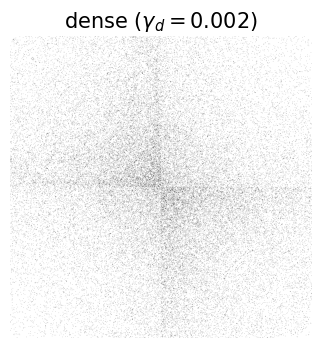

In [8]:
im = imshow(A_d - np.eye(n), cmap=cm.binary)
plt.title(r"dense $(\gamma_d=$" + f'{gamma_d})', fontsize=15)
plt.axis("off")
plt.show()

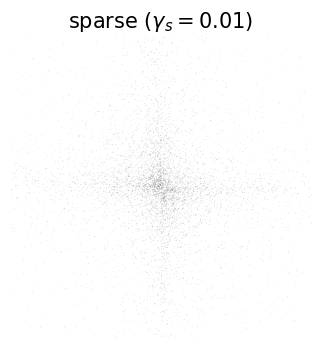

In [9]:
gamma_s = 0.01
A_s = sample_graphon(w_func, n, gamma_s, p, q)
imshow(A_s - np.eye(n), cmap=cm.binary)
plt.title(r"sparse $(\gamma_s = 0.01)$", fontsize=15)
plt.axis("off")
plt.show()

### Methods

In [10]:
def gaussian_features(n, in_feats, cov_scale, mean_scale=1, seed=0):
  '''
  n: number of nodes per block
  in_feats: input feature dimension
  cov_scale: scaling factor for covariance matrix
  return (2n x in_feats) feature matrix, where the first n rows are sample iid from N([1,...1], cov_scale*I), 
  the last n rows are sample iid from N([-1,...-1], cov_scale*I)
  '''
  np.random.seed(seed)
  mean = mean_scale*np.ones(in_feats)
  cov = cov_scale*np.eye(in_feats)
  feat_1 = np.random.multivariate_normal(mean, cov, n//2)
  feat_2 = np.random.multivariate_normal(-mean, cov, n//2)
  features = np.concatenate((feat_1, feat_2), axis=0)
  return features

In [11]:
def embed(A, Xouter, d=2, scale=False):
  '''
  Embed the normalize graph/covariance matrix together
  '''
  try: #error may occur if d is too large
    evalues, evectors = eigsh(A, k=d)
  except ArpackError:
  	for i in range(1,30):
  	  try:
  	    evalues, evectors = eigsh(A, k=d-i)
  	  except ArpackError:
  	  	continue
  	  else:
  	  	print(f"successfully solve sparse SVD at k={d-i}")
  	  	break
  evaluesX, evectorsX = eigsh(Xouter, k=d)

  if scale:
    ASE = evectors[:, :d] * evalues[:d]
    covX = evectorsX[:, :d] * evaluesX[:d]
  else:
    ASE = evectors[:, :d]
    covX = evectorsX[:, :d]

  return torch.FloatTensor(np.concatenate((ASE, covX), axis=1))

In [12]:
def FilterFunction(weights, S, x):
    '''
    weights is a list of length k, with each element of shape d_in x d_out
    S is N x N, sparse matrix
    x is N x d, d-dimensional feature (i.e., unique node ID in the featureless setting)
    '''    
    # Number of filter taps
    K = len(weights)
    
    # Number of output features
    F = weights[0].shape[1]
 
    # Number of input features
    G = weights[0].shape[0]
    
    # Number of nodes
    N = S.shape[0]

    # Create list to store graph diffused signals
    zs = [x]
    
    # Loop over the number of filter taps / different degree of S
    for k in range(1, K):        
        # diffusion step, S^k*x
        x = torch.spmm(S, x) #torch.matmul(x, S) -- slow
        # append the S^k*x in the list z
        zs.append(x)
    
    # sum up
    out = [z @ weight for z, weight in zip(zs, weights)]
    out = torch.stack(out)
    y = torch.sum(out, axis=0)
    return y
    

class Graph_Perception(nn.Module):
    '''
    k: the degree of polynomial (on the graph operator) 
    f_in: input feature dimension
    f_out: output feature dimension
    '''
    def __init__(self, k, f_in, f_out, nonlinear=True):
        super().__init__()
        self.k = k
        self.f_in = f_in
        self.f_out = f_out
        self.weight = nn.ParameterList([nn.Parameter(torch.randn(self.f_in,self.f_out)) for k in range(self.k)])
        self.nonlinear_flag = nonlinear
        if nonlinear:
          self.act = nn.PReLU()
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.f_in * self.k)
        for elem in self.weight:
          elem.data.uniform_(-stdv, stdv)

    def forward(self, x, gso):
        y = FilterFunction(self.weight, gso, x)
        if self.nonlinear_flag:
          return self.act(y)
        else:
          return y  

class GNN(nn.Module):
    def __init__(self, k, input_dim, hidden_dim, out_dim, num_layer, nonlinear=True):
        super().__init__()  
        self.k = k
        self.layers = nn.ModuleList()
        assert num_layer > 1, "must have at least 1 input layer and 1 output layer"
        # input layer
        self.layers.append(Graph_Perception(k, input_dim, hidden_dim, nonlinear=nonlinear))
        # hidden layers
        for i in range(num_layer - 2):
            self.layers.append(Graph_Perception(k, hidden_dim, hidden_dim, nonlinear=nonlinear))
        # output layer
        self.layers.append(Graph_Perception(1, hidden_dim, out_dim, nonlinear=False)) #output is a linear layer!

    def forward(self, x, gso):
      y = x
      for layer in self.layers:     
        y = layer(y, gso)
      return y

In [13]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, input_dim, hidden_dim, out_dim, n_layers=2, dropout=0.5):
    super().__init__()
    self.layers = nn.ModuleList()
    self.n_layers = n_layers
    if n_layers == 1:
        self.layers.append(nn.Linear(input_dim, out_dim))
    else:
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for i in range(n_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, out_dim))
    if self.n_layers > 1:
        self.prelu = nn.PReLU()
        #self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    self.reset_parameters()

  def reset_parameters(self):
    gain = nn.init.calculate_gain("relu")
    for layer in self.layers:
        nn.init.xavier_uniform_(layer.weight, gain=gain)
        nn.init.zeros_(layer.bias)


  def forward(self, x):
    for layer_id, layer in enumerate(self.layers):
        x = layer(x)
        if layer_id < self.n_layers - 1:
            x = self.dropout(self.prelu(x))
    return x

In [14]:
def evaluate(model, features, g, labels, mask):
    model.eval()
    with torch.no_grad():
      if g is None:
        logits = model(features)
      else:
        logits = model(features, g)
      logits = logits[mask]
      labels = labels[mask]
      _, indices = torch.max(logits, dim=1)
      correct = torch.sum(indices == labels)
      return correct.item() * 1.0 / len(labels)

def run_models(features, Ys, g, n, train_mask, in_feats=2, hidden_dim=8, out_feats=2, k=2, depth=3, act=False, lr=0.01, n_epochs=200, 
             tol=1e-5, MC_runs=5, verbose = False, return_model=False, GNN_flag=True):
  '''
  Semi-supervised graph learning
  '''
  results = []
  loss_fcn = torch.nn.CrossEntropyLoss()
  for run in range(MC_runs):
    # create model instance: K => number of layers (Message Passing)
    if GNN_flag:
      #print(depth)
      model = GNN(k=k, input_dim=in_feats, hidden_dim=hidden_dim, out_dim=out_feats, num_layer=depth, nonlinear=act) 
    else:
      model = MLP(input_dim=in_feats, hidden_dim=hidden_dim, out_dim=out_feats)
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr)
    prev_loss = 999

    # training
    for epoch in range(n_epochs):
        model.train()
        # forward
        if GNN_flag:
          logits = model(features, g)
        else:
          logits = model(features)
        loss = loss_fcn(logits[train_mask], Ys[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc_train = evaluate(model, features, g, Ys, mask=train_mask)
        acc = evaluate(model, features, g, Ys, mask=~train_mask)
        if verbose and (epoch % 10 == 0):
          print("Epoch {:05d} | Loss {:.4f} | Train_Accuracy {:.4f} | Test_Accuracy {:.4f} |". format(epoch,  loss.item(),acc_train, acc))
        if abs(prev_loss - loss.item()) < tol:
          break
        prev_loss = loss.item()
    
    results.append(acc)
  
  if return_model:
    return results, model
  else:
    return results

In [18]:
def run_MC(n, gamma, p, q, runs=10, train_pct=0.5, in_feats=2, hidden_dim=8, out_feats=2, k=2, depth=3, act=False, 
           lr=0.02, n_epochs=200, project=True, return_model=False, scale=False, verbose=False, norm_flag=True):
  '''
  Run Monte-Carlo simulation on random SBM with p, q parameters
  Return: accuracy of ASE; accuracy of GNN
  '''
  #data
  Ys = torch.cat((torch.ones(n//2), torch.zeros(n//2))).long()
  Ys = Ys.cuda()
  #Ys = Ys.cuda()
  results = {'SE(2)': [], 'SE(6)':[], 'SE(10)':[], 'SE(20)':[], 'GNN(lin)': [], 'GNN(non)': []}

  for run in range(runs):
    graph = sample_graphon(w_func, n, gamma, p, q, seed=run)
    graph = graph.astype(float)
    if norm_flag: #use normalized adjacency
      degs = graph.sum(axis=0).clip(min=1)
      norm = np.power(degs, -0.5)
      graph = np.diag(norm) @ graph @ np.diag(norm)
    features = gaussian_features(n, in_feats=in_feats, cov_scale=4, seed=run)
    #cov
    Xouter = features @ features.T
    train_mask = torch.cuda.FloatTensor(n).uniform_() > (1-train_pct) #torch.ByteTensor(2*n)
    train_mask = train_mask.cpu().numpy()

    #ASEs
    for dim, name in zip([2,6,10, 20], list(results.keys())[:-2]):
      feats = embed(graph, Xouter, d=dim)
      acc_spectral = run_models(feats.cuda(), Ys, None, n, train_mask, feats.shape[1], hidden_dim, out_feats, k, depth, act, lr, n_epochs, 
                            MC_runs=5, verbose = verbose, GNN_flag=False)    
      results[name].append(np.array(acc_spectral).mean()) #(np.array(acc_ASE).mean())#
      #print(f"sp={dim}, result={acc_spectral}")

    #GNN
    g_tensor = torch.FloatTensor(graph).to_sparse() #construct graph random walk operator
    feat_tensor = torch.cuda.FloatTensor(features)#np.eye(n))
    if return_model:
      acc_GNN, model_GNN = run_models(feat_tensor, Ys, g_tensor.cuda(), n, train_mask, return_model=True, GNN_flag=True)
      acc_GNN_non, model_GNN_non = run_models(feat_tensor, Ys, g_tensor.cuda(), n, train_mask, return_model=True, GNN_flag=True, act=True)

    else:
      acc_GNN = run_models(feat_tensor, Ys, g_tensor.cuda(), n, train_mask, GNN_flag=True)   
      acc_GNN_non = run_models(feat_tensor, Ys, g_tensor.cuda(), n, train_mask, return_model=True, GNN_flag=True, act=True)

    results['GNN(lin)'].append(np.array(acc_GNN).mean())
    results['GNN(non)'].append(np.array(acc_GNN_non).mean())
    #print(f"GNN(lin): {acc_GNN} GNN(non):{acc_GNN_non}")


  if return_model:
    return results, model_GNN, model_GNN_non, g_tensor, feat_tensor
  else:
    return results

In [16]:
##test run
torch.manual_seed(0)
# data params
in_feats = 2
features = gaussian_features(n, in_feats, cov_scale=4)
Ys = torch.cat((torch.ones(n//2), torch.zeros(n//2))).long()
train_pct = 0.5
train_mask = torch.cuda.FloatTensor(n).uniform_() > (1-train_pct) #torch.ByteTensor(2*n)
n_runs = 10

In [19]:
#run model!
###Normalized adjacency
# result_d, model_d, model_d_non, A_d, feat_d = run_MC(n, gamma_d, p, q, runs=n_runs, return_model=True)
# result_s, model_s, model_s_non, A_s, feat_s = run_MC(n, gamma_s, p, q, runs=n_runs, return_model=True)
###Un-normalized adjacency
result_d, model_d, model_d_non, A_d, feat_d = run_MC(n, gamma_d, p, q, runs=n_runs, return_model=True, norm=False)
result_s, model_s, model_s_non, A_s, feat_s = run_MC(n, gamma_s, p, q, runs=n_runs, return_model=True, norm=False)

In [25]:
df_list = []
names = [r'dense $A_d$',r'sparse $A_s$']
for name, result in zip(names, [result_d, result_s]):
  df = pd.DataFrame.from_dict(result,orient='index').transpose() 
  df = pd.melt(df, value_vars=['SE(2)', 'SE(6)', 'SE(10)', 'SE(20)', 'GNN(lin)', 'GNN(non)'])
  df['mode'] = name
  df_list.append(df)
df_all = pd.concat(df_list, ignore_index=True)
df_all.columns = ['method', 'test_accuracy','sparsity']
#df_all['method'] = df_all.apply (lambda row: relabel(row), axis=1)


In [26]:
# def relabel(row):
#   a = row['method']
#   if a[:2] == 'SP':
#     if len(a) == 5:
#       return 'LSE' + f'({a[3]})'
#     elif len(a) == 6:
#       return 'LSE' + f'({a[3:5]})'
#   else:
#     return a


# def relabel_again(row):
#   a = row['method']
#   if a[:3] == 'LSE':
#     return 'SE' + a[3:]
#   else:
#     return a

# df_all_norm = pickle.load(open( "result/results_sampling_DCSBM.pkl", "rb" ) )
# df_all_norm['method'] = df_all_norm.apply (lambda row: relabel_again(row), axis=1)


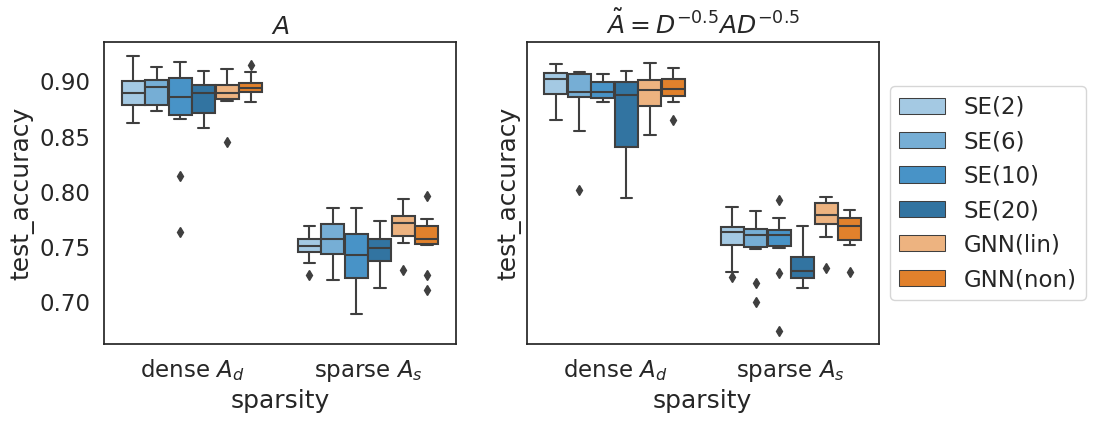

In [39]:
df_all_norm = pickle.load(open( "result/results_sampling_DCSBM.pkl", "rb" ) )
df_all = pickle.load(open( "result/results_sampling_DCSBM_un.pkl", "rb" ) )

sns.set(font_scale=1.5)
sns.set_style(style='white') 
plt.rcParams["figure.figsize"] = (8,5)
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10,4), dpi=100)
# my_pal = {'LSE(2)':lighten_color('tab:blue', 0.4), 'LSE(6)':lighten_color('tab:blue', 0.6), 'LSE(10)':lighten_color('tab:blue', 0.8), 
#           'LSE(20)':'tab:blue', 'GNN(lin)': lighten_color('tab:orange', 0.6), 'GNN(non)':'tab:orange'}
my_pal = {'SE(2)':lighten_color('tab:blue', 0.4), 'SE(6)':lighten_color('tab:blue', 0.6), 'SE(10)':lighten_color('tab:blue', 0.8), 
          'SE(20)':'tab:blue', 'GNN(lin)': lighten_color('tab:orange', 0.6), 'GNN(non)':'tab:orange'}

sns.boxplot(x="sparsity", y="test_accuracy",
            hue="method", palette=my_pal,
            data=df_all, ax=axs[0]).set_title(r"$A$")
axs[0].get_legend().remove()

sns.boxplot(x="sparsity", y="test_accuracy",
            hue="method", palette=my_pal,
            data=df_all_norm, ax=axs[1]).set_title(r"$\tilde{A} = D^{-0.5} A D^{-0.5}$")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

In [35]:
### Saving results
# pickle.dump( df_all, open( "result/results_sampling_DCSBM.pkl", "wb" ) )
# pickle.dump( (model_d, model_d_non, A_d, feat_d),
#             open( "result/results_sampling_model_dense_DCSBM.pkl", "wb" ) )
# pickle.dump( (model_s, model_s_non, A_s, feat_s),
#             open( "result/results_sampling_model_sparse_DCSBM.pkl", "wb" ) )

#### Let's visualize the frequency responses of the learned GNNs!

In [ ]:
#CAUTION: eigenvalue/eigenvector returned in ASCENDING ORDER
def eigen_decomposition(A):
  '''
  Input: perform spectral decomposition for pytorch tensor (sparse format)
  '''
  A_dense = A.to_dense()
  #print(torch.allclose(A_dense, A_dense.T, rtol=1e-05, atol=1e-08))
  evals, evectors = torch.linalg.eigh(A_dense)
  sortedEig, indices = evals.sort(dim=0, descending=True)#evals.argsort()[::-1]   
  evectors = evectors[:,indices ]
  return sortedEig, evectors

In [ ]:
def get_freq_response(A, feature, model, normalize=True):
  '''
  Given graph A, graph signal feature, and trained GNN model
  Return the frequency response (embedding in the Fourier domain)
  '''
  sigma, U = eigen_decomposition(A)
  hatFeat = U.T @ feature
  model.eval()
  out = model(feature, A)
  freq_response = (U.T @ out).data.numpy() 
  if normalize:
    freq_response /= np.max(np.abs(freq_response), axis=0)
  return freq_response, sigma 


In [ ]:
def plot_freq(A, feature, model, normalize=True):
  freq_response, sigma = get_freq_response(A, feature.cpu(), model.cpu(), normalize)

  fig, ax = plt.subplots(figsize=(8,5), dpi=100)
  ax.plot(freq_response[:, 0], label=r"$\hat{\mathbf{y}}_{[:,0]}$", color="tab:blue", alpha=0.7)
  ax.plot(freq_response[:, 1], label=r"$\hat{\mathbf{y}}_{[:,1]}$", color="tab:orange", alpha=0.7)
  
  ax.legend(loc='lower left')
  ax.plot(sigma, linestyle="--", label=r'$\lambda(\tilde{A})$', color="grey", alpha=0.7)

  ax.legend()
  ax.set_xlabel("Frequency Component")
  ax.set_ylabel("Relative Magnitude")
  plt.show()
  return freq_response, sigma

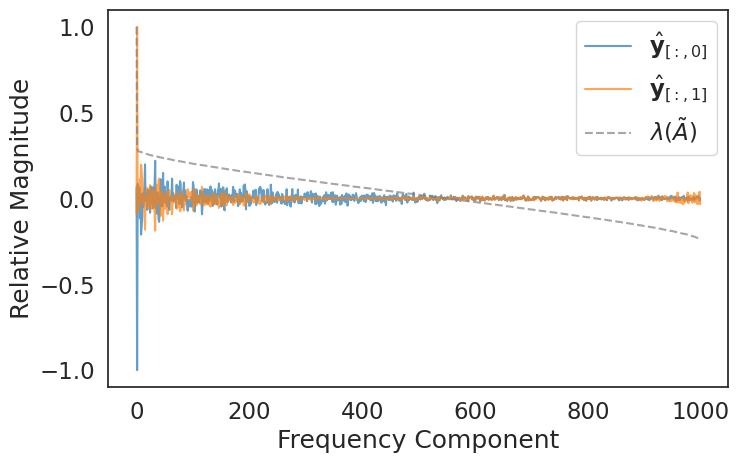

In [ ]:
freq_d, sigma_d = plot_freq(A_d, feat_d, model_d)

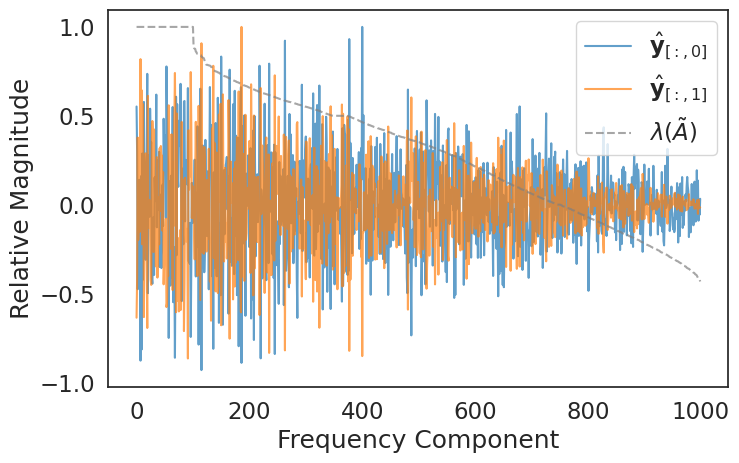

In [ ]:
freq_s, sigma_s = plot_freq(A_s, feat_s, model_s)

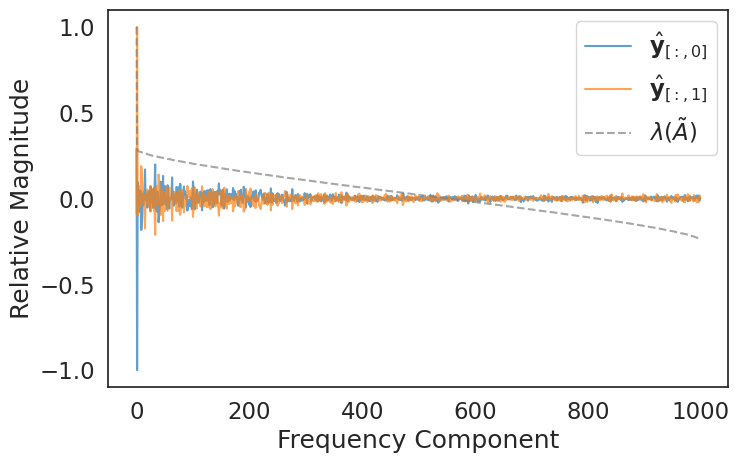

In [ ]:
freq_d_non, sigma_d_non = plot_freq(A_d, feat_d, model_d_non)

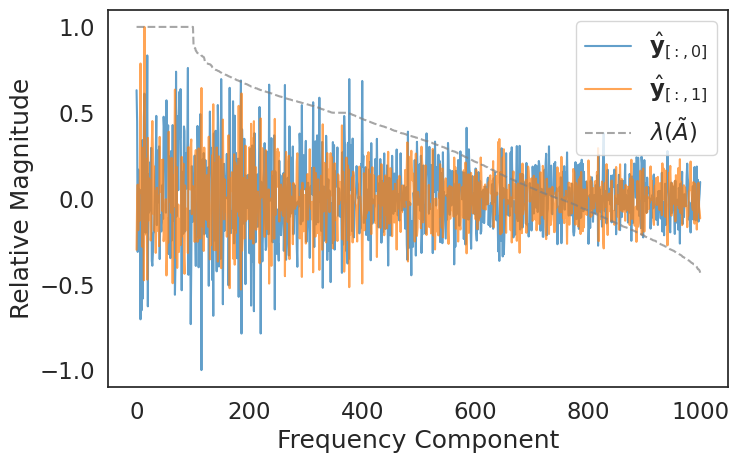

In [ ]:
freq_s_non, sigma_s_non = plot_freq(A_s, feat_s, model_s_non)